## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Reading the sms spam data using pandas

In [2]:
df=pd.read_csv('train.csv')
print('Shape : ',df.shape)
df.head()

Shape :  (5574, 2)


sms  label
0  Go until jurong point, crazy.. Available only ...      0
1                    Ok lar... Joking wif u oni...\n      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0

### Removing missing and duplicate data

In [3]:
df=df.dropna()

In [4]:
duplicate_rows = df[df.duplicated()]
print('Number of duplicate Reviews : ',len(duplicate_rows))

Number of duplicate Reviews :  403


In [5]:
df = df.drop_duplicates()

In [6]:
df.reset_index(inplace=True)

In [7]:
df = df.drop(["index"],axis=1)

## Data Analysis

Analysing the statistical measures of the data:

In [8]:
df.describe()

label
count  5171.000000
mean      0.126281
std       0.332198
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

Displaying the Datatype and the number of Non-Null values of each column in the dataset:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5171 non-null   object
 1   label   5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


Analysing the target variable count to check whether the data is biased to any of the target variable:

In [10]:
df['label'].value_counts()

0    4518
1     653
Name: label, dtype: int64

Analysing the Null values w.r.t each feature:

In [11]:
df.isna().sum()

sms      0
label    0
dtype: int64

In [12]:
df

sms  label
0     Go until jurong point, crazy.. Available only ...      0
1                       Ok lar... Joking wif u oni...\n      0
2     Free entry in 2 a wkly comp to win FA Cup fina...      1
3     U dun say so early hor... U c already then say...      0
4     Nah I don't think he goes to usf, he lives aro...      0
...                                                 ...    ...
5166  This is the 2nd time we have tried 2 contact u...      1
5167             Will ü b going to esplanade fr home?\n      0
5168  Pity, * was in mood for that. So...any other s...      0
5169  The guy did some bitching but I acted like i'd...      0
5170                       Rofl. Its true to its name\n      0

[5171 rows x 2 columns]

### Count plots on the Target variable

In [13]:
# Function to update values based on column_A
def update_values(row):
    if row['label'] == 0:
        return 'Non Spam'
    else:
        return 'Spam'

# Create a new column and update its values
df['Spam/NonSpam'] = df.apply(update_values, axis=1)

In [14]:
attributes = list(pd.DataFrame(df["Spam/NonSpam"].value_counts()).index)
fig = px.pie(pd.DataFrame(df["Spam/NonSpam"].value_counts()),values="Spam/NonSpam", names=attributes,width=900, height=500)
fig.update_layout(
    title_text="Distribution of Spam and Non-Spam messages",
    title_x=0.5
)
fig.show()

Text(0.5, 1.0, 'Distribution of Spam and Non-Spam messages')

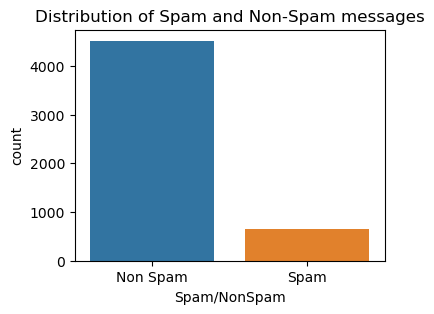

In [15]:
plt.figure(figsize=(4,3))
sns.countplot(x='Spam/NonSpam', data=df)
plt.title("Distribution of Spam and Non-Spam messages")

In [16]:
df['Word_length'] = df['sms'].apply(lambda x: len(x.split()))

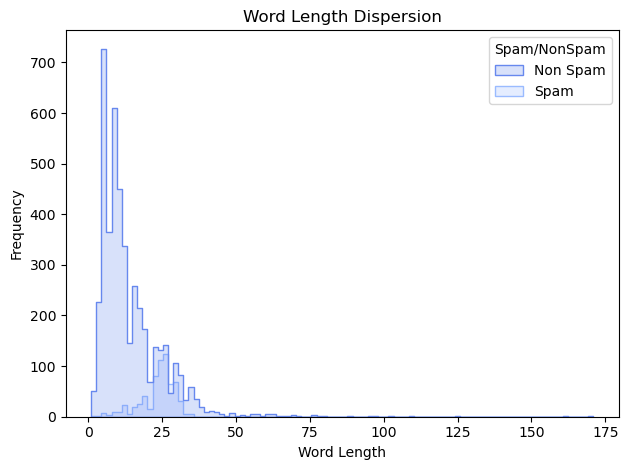

In [17]:
sns.set_palette("coolwarm")
sns.histplot(data=df, x='Word_length', hue='Spam/NonSpam', element='step')
plt.title('Word Length Dispersion')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Text Cleaning and preprocessing:

In [18]:
!pip install clean-text

In [19]:
from cleantext.sklearn import CleanTransformer
cleaner = CleanTransformer(
    no_line_breaks=False,           
    no_urls=True,                  
    no_emails=True,                
    no_phone_numbers=True,         
    no_numbers=True,               
    no_digits=True,                
    no_currency_symbols=True,      
    no_punct=True,                 
    replace_with_punct="",          
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       
)
preprocessed_text = cleaner.transform(list(df['sms'].values))

In [20]:
stop_words = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

In [21]:
print(df["sms"][5])
print(preprocessed_text[5])

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv

freemsg hey there darling its been <number> weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send <cur><number> to rcv


In [22]:
df["preprocessed_text"] = preprocessed_text

In [23]:
from tqdm import tqdm
from nltk.stem import PorterStemmer

from nltk.corpus import stopwords
preprocessed_text = []
stemmer = PorterStemmer()
for text in tqdm(df["preprocessed_text"].values):
    words = text.split(" ")
    stemmed_words = [stemmer.stem(word) for word in words]
    words = [word for word in stemmed_words if word not in stop_words]
    preprocessed_text.append(" ".join(words))

100%|████████████████████████████████████████████████████████████████████████████| 5171/5171 [00:02<00:00, 2253.71it/s]


In [24]:
df["preprocessed_text"] = preprocessed_text

In [25]:
df.to_csv("preprocessed_data.csv",index=None)

### Identifying the unique words in the cleaned sms:

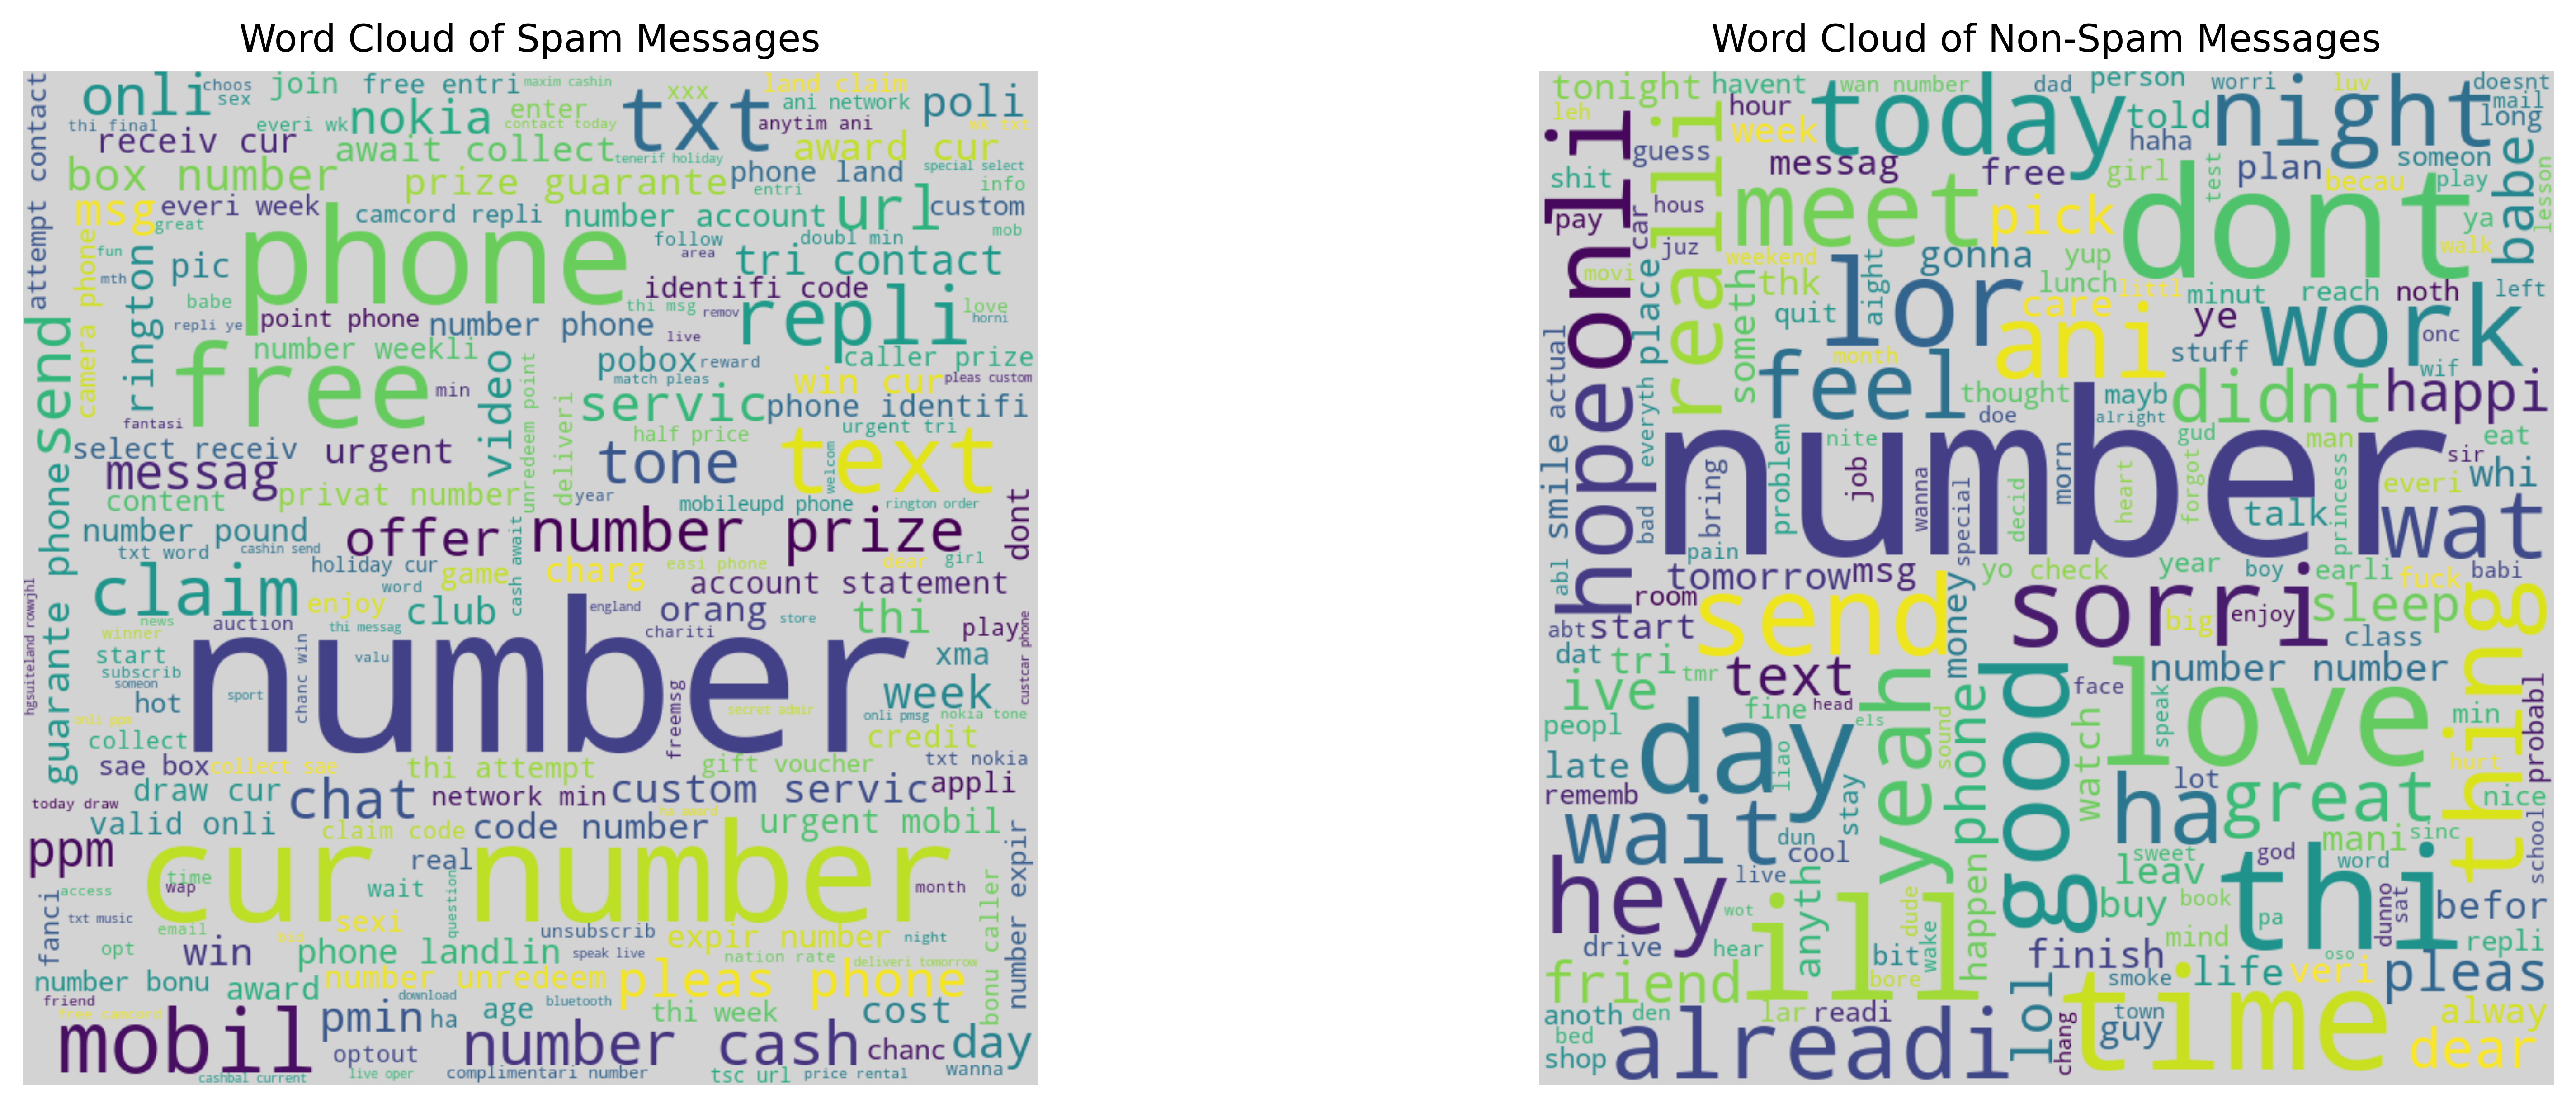

In [26]:
from wordcloud import WordCloud
spam = " ".join(df[df['label'] == 1]['preprocessed_text'])
spam_wc = WordCloud(width=700, height=700, background_color='lightgrey').generate(spam)
spam_image = spam_wc.to_array()
non_spam = " ".join(df[df['label'] == 0]['preprocessed_text'])
nonspam_wc = WordCloud(width=700, height=700, background_color='lightgrey').generate(non_spam)
nonspam_image = nonspam_wc.to_array()

plt.figure(figsize=(15, 5), dpi=500)

plt.subplot(1, 2, 1)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Word Cloud of Spam Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nonspam_image, interpolation='bilinear')
plt.title('Word Cloud of Non-Spam Messages')
plt.axis('off')

plt.tight_layout()
plt.show()

### Distribution plot of length of the sms:

In [27]:
l = []
for x in df["preprocessed_text"] :
    l.append(len(x.split()))


In [28]:
df["Review_length"] = l

In [29]:
import numpy as np
np.mean(df["Review_length"])

6.727518855153742

In [30]:
df.describe()

label  Word_length  Review_length
count  5171.000000  5171.000000    5171.000000
mean      0.126281    15.433765       6.727519
std       0.332198    11.102059       5.348929
min       0.000000     1.000000       0.000000
25%       0.000000     7.000000       3.000000
50%       0.000000    12.000000       5.000000
75%       0.000000    22.000000      10.000000
max       1.000000   171.000000      61.000000

<Axes: xlabel='Review_length'>

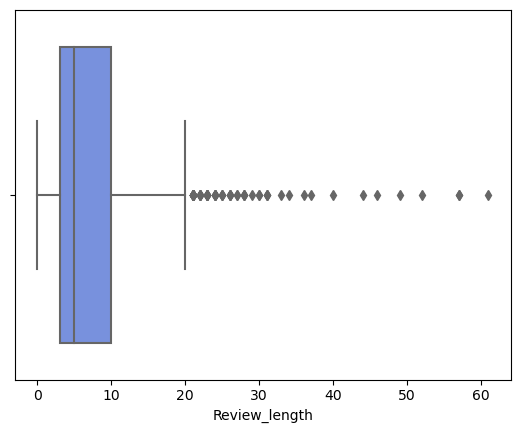

In [31]:
import seaborn as sns

sns.boxplot(x=df["Review_length"])

## Machine Learning Algorithm

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### TF-IDF Vectorization, Splitting the train and test data

In [34]:
X = df['preprocessed_text'].values
Y = df['label'].values
X = TfidfVectorizer().fit_transform(X)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=None)

### Naive Bayes Classifier

In [36]:
from sklearn.naive_bayes import MultinomialNB
nbc =  MultinomialNB(alpha=0.1)
nbc.fit(X_train,Y_train)

MultinomialNB(alpha=0.1)

In [37]:
y_pred = nbc.predict(X_train)
print("Training Results")
print("Training Accuracy  : {:.2f}".format(round(accuracy_score(Y_train,y_pred),2)))
print("Training Precision : {:.2f}".format(round(precision_score(Y_train,y_pred),2)))
print("Training Recall    : {:.2f}".format(round(recall_score(Y_train,y_pred),2)))
print("Training F1-Score  : {:.2f}".format(round(f1_score(Y_train,y_pred),2)))

Training Results
Training Accuracy  : 1.00
Training Precision : 0.99
Training Recall    : 0.98
Training F1-Score  : 0.99


In [38]:
y_pred = nbc.predict(X_test)
print("Testing Results")
print("Testing Accuracy  : {:.2f}".format(round(accuracy_score(Y_test,y_pred),2)))
print("Testing Precision : {:.2f}".format(round(precision_score(Y_test,y_pred),2)))
print("Testing Recall    : {:.2f}".format(round(recall_score(Y_test,y_pred),2)))
print("Testing F1-Score  : {:.2f}".format(round(f1_score(Y_test,y_pred),2)))

Testing Results
Testing Accuracy  : 0.96
Testing Precision : 0.84
Testing Recall    : 0.89
Testing F1-Score  : 0.86


### Confusion Matrix

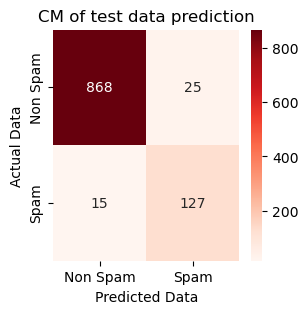

In [39]:
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'])
plt.title('CM of test data prediction')
plt.xlabel('Predicted Data')
plt.ylabel('Actual Data')
plt.show()

## Deep Learning

### Splitting the data into train and test:

In [43]:
labels = df['label'].values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df["preprocessed_text"],labels, test_size=0.2, random_state=None)

In [44]:
max_len = 20
trunc_type = "post"
padding_type = "pre"
oov_tok = "<OOV>"

In [45]:
token = Tokenizer(char_level=False, oov_token = oov_tok) # oov_token is used for out of vocabulary
token.fit_on_texts(preprocessed_text)

In [46]:
#token.word_index
len(token.word_index)

6747

In [47]:
token.word_index

{'<OOV>': 1,
 'number': 2,
 'phone': 3,
 'thi': 4,
 'cur': 5,
 'dont': 6,
 'free': 7,
 'time': 8,
 'day': 9,
 'love': 10,
 'good': 11,
 'ill': 12,
 'text': 13,
 'onli': 14,
 'send': 15,
 'lor': 16,
 'today': 17,
 'txt': 18,
 'repli': 19,
 'mobil': 20,
 'pleas': 21,
 'ani': 22,
 'sorri': 23,
 'work': 24,
 'hope': 25,
 'week': 26,
 'ha': 27,
 'meet': 28,
 'night': 29,
 'hey': 30,
 'tri': 31,
 'wait': 32,
 'thing': 33,
 'happi': 34,
 'wat': 35,
 'great': 36,
 'claim': 37,
 'messag': 38,
 'dear': 39,
 'alreadi': 40,
 'friend': 41,
 'url': 42,
 'yeah': 43,
 'feel': 44,
 'realli': 45,
 'msg': 46,
 'babe': 47,
 'min': 48,
 'prize': 49,
 'tomorrow': 50,
 'ye': 51,
 'didnt': 52,
 'pick': 53,
 'ive': 54,
 'leav': 55,
 'whi': 56,
 'care': 57,
 'lol': 58,
 'anyth': 59,
 'year': 60,
 'sleep': 61,
 'morn': 62,
 'veri': 63,
 'someth': 64,
 'buy': 65,
 'servic': 66,
 'contact': 67,
 'finish': 68,
 'life': 69,
 'everi': 70,
 'watch': 71,
 'befor': 72,
 'cash': 73,
 'start': 74,
 'win': 75,
 'nokia': 76

In [48]:
vocab_size = len(token.word_index)+1 # 1 is added because of padding (0) and one more thing 0 is not present in tokenizer vocabulary it will start from 1

In [49]:
vocab_size

6748

In [50]:
word_index = token.word_index
c = list(word_index.keys())
c[0:10]

['<OOV>',
 'number',
 'phone',
 'thi',
 'cur',
 'dont',
 'free',
 'time',
 'day',
 'love']

#### Replacing each english token with the respective token number and if required applying truncation and then padding the sequences :

In [51]:
x_train_seq = token.texts_to_sequences(X_train)
train_pad_seq = pad_sequences (x_train_seq, maxlen = max_len, padding = padding_type, truncating = trunc_type )
x_test_seq = token.texts_to_sequences(X_test)
test_pad_seq = pad_sequences(x_test_seq, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [52]:
print('Shape of training Reviews: ', train_pad_seq.shape)
print('Shape of testing Reviews: ', test_pad_seq.shape)

Shape of training Reviews:  (4136, 20)
Shape of testing Reviews:  (1035, 20)


In [53]:
print('Actual Review:\n',X_train.iloc[7])
print('\nsms sentence represented in terms of tokens and not padded :\n ',x_train_seq[7])
print('\nAfter padding : \n',train_pad_seq[7])

Actual Review:
 aww time love

sms sentence represented in terms of tokens and not padded :
  [2439, 8, 10]

After padding : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 2439    8   10]


In [54]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# matplotlib
import matplotlib.pyplot as plt

## Applying Model's:

## LSTM's

In [56]:
n_lstm = 512 # it should be multiple 32 :-  
embeding_dim =128
drop_lstm =0.2
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 128)           863744    
                                                                 
 lstm (LSTM)                 (None, 512)               1312768   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 2177025 (8.30 MB)
Trainable params: 2177025 (8.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
num_epochs = 10 # 20,30,40
history = model1.fit(train_pad_seq,Y_train, epochs=num_epochs,validation_data=(test_pad_seq, Y_test), verbose=2)

Epoch 1/10
130/130 - 34s - loss: 0.1545 - accuracy: 0.9480 - val_loss: 0.0444 - val_accuracy: 0.9865 - 34s/epoch - 260ms/step
Epoch 2/10
130/130 - 31s - loss: 0.0455 - accuracy: 0.9869 - val_loss: 0.0353 - val_accuracy: 0.9913 - 31s/epoch - 236ms/step
Epoch 3/10
130/130 - 35s - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0951 - val_accuracy: 0.9826 - 35s/epoch - 271ms/step
Epoch 4/10
130/130 - 29s - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0300 - val_accuracy: 0.9894 - 29s/epoch - 220ms/step
Epoch 5/10
130/130 - 29s - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.0364 - val_accuracy: 0.9874 - 29s/epoch - 221ms/step
Epoch 6/10
130/130 - 29s - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0303 - val_accuracy: 0.9923 - 29s/epoch - 225ms/step
Epoch 7/10
130/130 - 28s - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0390 - val_accuracy: 0.9874 - 28s/epoch - 212ms/step
Epoch 8/10
130/130 - 28s - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.0427 - val_accuracy: 0.9923 - 28s/epoch - 212

In [58]:
model = model1
# predict probabilities for test set
yhat_probs = model.predict(test_pad_seq, verbose=0)
# predict crisp classes for test set
yhat_classes = (model.predict(test_pad_seq)>0.5).astype('int32')

yhat_classes = yhat_classes[:, 0]

#classification report
matrix = classification_report(Y_test, yhat_classes,digits=4)
print(matrix)

33/33 [==============================] - 2s 58ms/step
              precision    recall  f1-score   support

           0     0.9922    0.9966    0.9944       892
           1     0.9784    0.9510    0.9645       143

    accuracy                         0.9903      1035
   macro avg     0.9853    0.9738    0.9795      1035
weighted avg     0.9903    0.9903    0.9903      1035



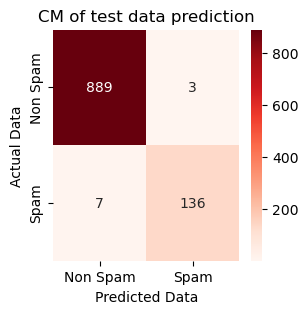

In [59]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, yhat_classes)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'])
plt.title('CM of test data prediction')
plt.xlabel('Predicted Data')
plt.ylabel('Actual Data')
plt.show()

## Bi-Directional LSTM's

In [60]:
drop_lstm =0.2
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [61]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 128)           863744    
                                                                 
 bidirectional (Bidirection  (None, 20, 1024)          2625536   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 1024)              6295552   
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 9785857 (37.33 MB)
Trainable params: 9785857 (37.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
num_epochs = 10
history = model2.fit(train_pad_seq, Y_train, epochs=num_epochs, validation_data=(test_pad_seq, Y_test), verbose=2)

Epoch 1/10
130/130 - 179s - loss: 0.1225 - accuracy: 0.9589 - val_loss: 0.0504 - val_accuracy: 0.9845 - 179s/epoch - 1s/step
Epoch 2/10
130/130 - 177s - loss: 0.0544 - accuracy: 0.9872 - val_loss: 0.1260 - val_accuracy: 0.9478 - 177s/epoch - 1s/step
Epoch 3/10
130/130 - 180s - loss: 0.0519 - accuracy: 0.9833 - val_loss: 0.1535 - val_accuracy: 0.9662 - 180s/epoch - 1s/step
Epoch 4/10
130/130 - 184s - loss: 0.0592 - accuracy: 0.9836 - val_loss: 0.0486 - val_accuracy: 0.9845 - 184s/epoch - 1s/step
Epoch 5/10
130/130 - 180s - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.0392 - val_accuracy: 0.9894 - 180s/epoch - 1s/step
Epoch 6/10
130/130 - 170s - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0334 - val_accuracy: 0.9874 - 170s/epoch - 1s/step
Epoch 7/10
130/130 - 183s - loss: 0.0103 - accuracy: 0.9966 - val_loss: 0.0373 - val_accuracy: 0.9865 - 183s/epoch - 1s/step
Epoch 8/10
130/130 - 173s - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0432 - val_accuracy: 0.9894 - 173s/epoch - 1s/step


In [63]:
model = model2
# predict probabilities for test set
yhat_probs = model.predict(test_pad_seq, verbose=0)
# predict crisp classes for test set
yhat_classes = (model.predict(test_pad_seq)>0.5).astype('int32')

yhat_classes = yhat_classes[:, 0]


#classification report
matrix = classification_report(Y_test, yhat_classes,digits=4)
print(matrix)

33/33 [==============================] - 12s 360ms/step
              precision    recall  f1-score   support

           0     0.9877    0.9910    0.9894       892
           1     0.9429    0.9231    0.9329       143

    accuracy                         0.9816      1035
   macro avg     0.9653    0.9571    0.9611      1035
weighted avg     0.9815    0.9816    0.9816      1035



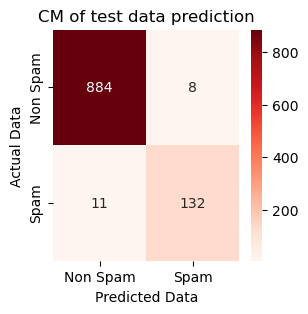

In [64]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, yhat_classes)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Non Spam', 'Spam'], yticklabels=['Non Spam', 'Spam'])
plt.title('CM of test data prediction')
plt.xlabel('Predicted Data')
plt.ylabel('Actual Data')
plt.show()

Text(0.5, 0, 'Classification Results')

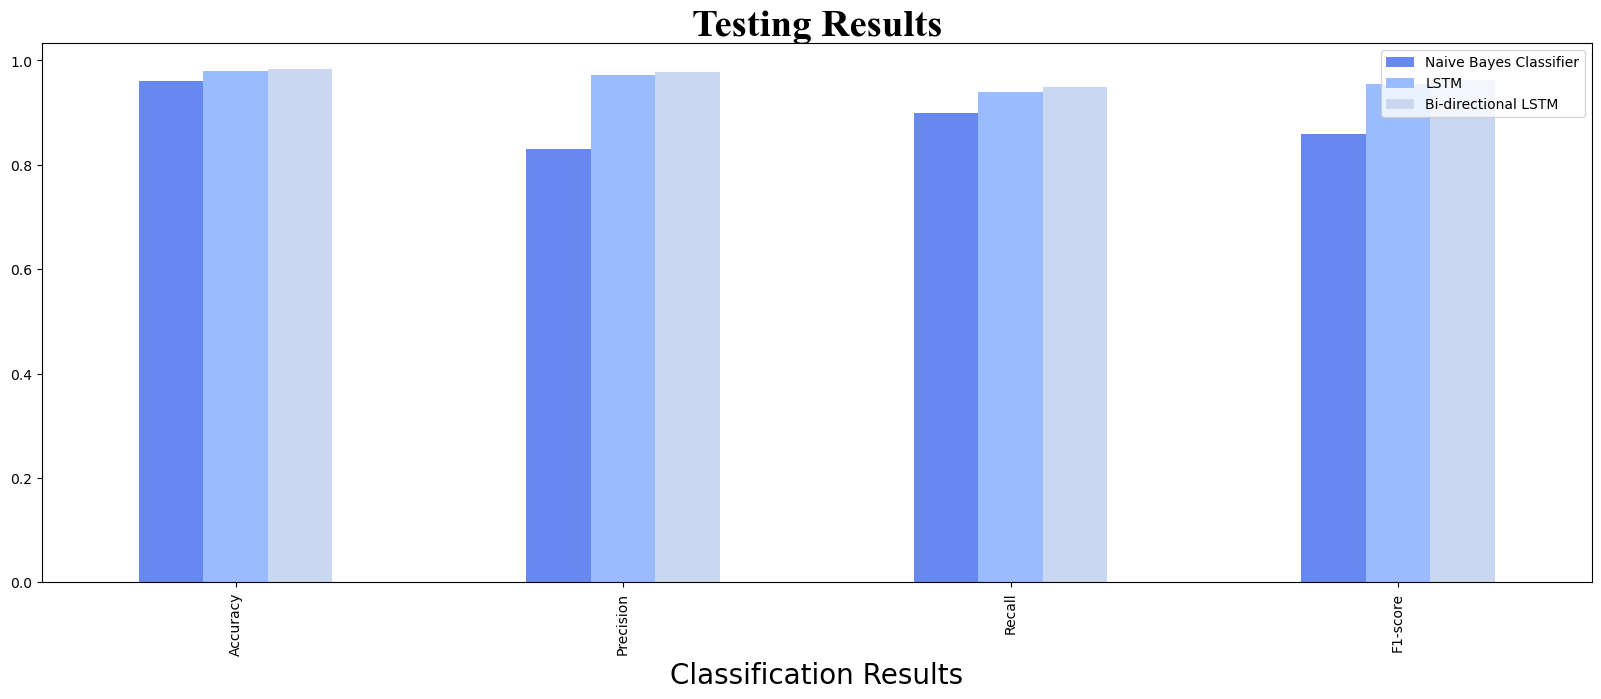

In [65]:
d=pd.DataFrame({"Naive Bayes Classifier":[0.96,0.83,0.90,0.86],"LSTM":[0.9803,0.9727,0.9392,0.9551],"Bi-directional LSTM":[0.9839,0.9781,0.9500,0.9635]},index=["Accuracy", "Precision", "Recall", "F1-score"])
d.plot(kind="bar",figsize=(20,7))
plt.title("Testing Results",fontname="Times New Roman", size=28,fontweight="bold")
plt.xlabel("Classification Results",size=20)